# Tutorial Modelos de Ensamble tipo Random Forest

En este tutorial aplicaremos un modelo de ensamble tipo Random Forest a una serie de precios. Este tutorial se enfoca a generar una estructura en los datos que permita un pronóstico hacia adelante. Es decir, buscamos generar una estructura de ensamble a un conjunto de datos condicionados a eventos pasados, para luego generar un pronóstico futuro de los mismos. La serie por tanto genera una estructura de ensamble entrenada en una sección correspondiente de entrenamiento para luego generar un pronóstico hacia adelante en una estructura de datos transformada y mediante un modelo con refinamiento de parámetros.

**Contenido**
1. [Importación de librerías requeridas](#2)
1. [Importación de datos financieros](#3)
1. [Visualización de datos financieros](#4)
1. [Preprocesamiento de datos](#5)
1. [Partición de datos en entrenamiento y prueba](#6)
1. [Visualización conjunto de entrenamiento y prueba](#7)
1. [Regresión con Random Forest](#7a)
1. [Creación del Forecaster](#8)
1. [Predicciones en conjuto de prueba](#9)
1. [Refinamiento de los hiperparámetros](#10)
1. [Aplicación modelo óptimo a serie completa](#11)
1. [Generación del pronóstico hacia adelante](#12)
1. [Visualización del pronóstico futuro](#13)

<a id="2"></a> <br>
### 1. Importación de librerías requeridas

Importa las siguientes librerías para desarrollar este tutorial:

In [1]:
pip install skforecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.2/169.2 kB 388.8 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 12.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.1/283.1 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.2/308.2 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 16.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 2.9 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.0.1
    Uninstalling joblib-1.0.1:
      Successfully uninstalled joblib-1.0.1
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.13.2
    Uninstalling statsmodels-0.13.2:
      Successfully uninstalled statsmodels-0.13.2
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3

In [2]:
#Esta es requerida para importar los datos financieros
!pip install yfinance

In [3]:
# Manipulación datos
import numpy as np
import pandas as pd

from numpy import array
#from keras.models import Sequential
#from keras.layers import Dense
from numpy import asarray
from pandas import DataFrame
from pandas import concat

# Gráficos
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from matplotlib import pyplot
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modelación y pronóstico
#Random Forest:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
##Regressor:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster


from joblib import dump, load


from datetime import datetime
from math import sqrt
# Configuración de warnings:
import warnings
# warnings.filterwarnings('ignore')

In [4]:
#Estas son paqueterías complementarias para la descarga de datos financieros
import pandas
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
##Si tienes problemas para descargar pandas datareader, puedes probar la siguiente línea:
#!pip install git+https://github.com/pydata/pandas-datareader.git

<a id="3"></a> <br>
### 2. Importación de datos financieros

Establecemos primeramente la fecha de inicio y fin, así como el activo o los activos de interés. En este ejemplo, emplearemos únicamente un activo, pero dejo desactivados otros ejemplos de stocks (stks), índices (idx), monedas (ccy) como ejemplos de otros activos.

In [5]:
#Establecemos las fechas de consulta:
start = '2015-01-01'
end = '2022-07-29'
#ticker = 'AAPL'
#data = pdr.get_data_yahoo(ticker, start, end)['Adj Close']
amzn='AMZN'
#stks_tickers = ['AAPL','IBM', 'GOOGL']
#idx_tickers = ['SPY', '^DJI', '^VIX']
#ccy_tickers = ['JPY=X', 'GBPUSD=X']

In [6]:
#Una vez declarado el ticker, pedimos a través de la función de pandas data reader (pdr), bajar lso datos de la fuente de yahoo finance.
amzn = pdr.get_data_yahoo("AMZN", start, end)['Close']

[*********************100%***********************]  1 of 1 completed


In [7]:
amzn.head()

Date
2015-01-02    15.4260
2015-01-05    15.1095
2015-01-06    14.7645
2015-01-07    14.9210
2015-01-08    15.0230
Name: Close, dtype: float64

In [8]:
#Pasamos a data frame los datos
dt= pandas.DataFrame(amzn)
dt.head()

,Close
Date,
2015-01-02,15.4260
2015-01-05,15.1095
2015-01-06,14.7645
2015-01-07,14.9210
2015-01-08,15.0230


In [9]:
#Identificamos la longitud de la serie
len(dt)

1906

In [10]:
#Damos un vistazo a los datos
dt.head()
dt.tail()
data = dt.rename(columns={'Close': 'y'})
data

,y
Date,
2015-01-02,15.426000
2015-01-05,15.109500
2015-01-06,14.764500
2015-01-07,14.921000
2015-01-08,15.023000
...,...
2022-07-22,122.419998
2022-07-25,121.139999
2022-07-26,114.809998


<a id="4"></a> <br>
### 3. Visualización de datos financieros

Para mirar la serie, debemos importar la librería de matplotlib.

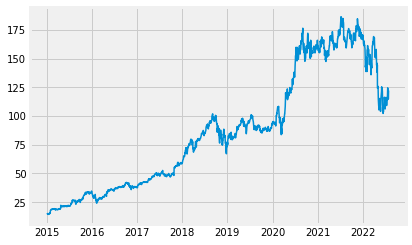

In [11]:
#Una vez llamada la librería, graficamos la serie dt.
import matplotlib.pyplot as plt
plt.plot(dt)

<a id="5"></a> <br>
### 4. Preprocesamiento de datos

En esta parte, debemos primero convertir nuestros datos tipo dataframe a un objeto de pandas con fecha. Igualmente, la parte de valores de la serie, como el precio, lo pasamos a un tipo NumPy array que facilitará el procesamiento. 

In [12]:
#Ahora, pasamos el data frame a un objeto de tiempo de pandas.
dataindex= pd.to_datetime(data.index)
dataindex

DatetimeIndex(['2015-01-02', '2015-01-05', '2015-01-06', '2015-01-07',
               '2015-01-08', '2015-01-09', '2015-01-12', '2015-01-13',
               '2015-01-14', '2015-01-15',
               ...
               '2022-07-15', '2022-07-18', '2022-07-19', '2022-07-20',
               '2022-07-21', '2022-07-22', '2022-07-25', '2022-07-26',
               '2022-07-27', '2022-07-28'],
              dtype='datetime64[ns]', name='Date', length=1906, freq=None)

<a id="6"></a> <br>
### 5. Partición de datos en entrenamiento y prueba

En esta seción, partimos el conjunto de datos de pueba y de entrenamiento. 

In [13]:
#Especificamos los últimos datos que servirán para la parte de testing o capacidad predictiva del modelo.
steps = 36
#Aplicamos dicha proporción a la definición de la parte de entrenamiento y de prueba.
data_train = data[:-steps]
data_test  = data[-steps:]

#Así también para las fechas:
date_train = dataindex[:-steps]
date_test = dataindex[-steps:]

In [14]:
#Vemos los datos para las fechas que nos sirven para las gráficas
date_train
#date_test  #Igualmente para visualizarlos

DatetimeIndex(['2015-01-02', '2015-01-05', '2015-01-06', '2015-01-07',
               '2015-01-08', '2015-01-09', '2015-01-12', '2015-01-13',
               '2015-01-14', '2015-01-15',
               ...
               '2022-05-23', '2022-05-24', '2022-05-25', '2022-05-26',
               '2022-05-27', '2022-05-31', '2022-06-01', '2022-06-02',
               '2022-06-03', '2022-06-06'],
              dtype='datetime64[ns]', name='Date', length=1870, freq=None)

In [15]:
#Imprimimos la longitud de ambos conjuntos de datos:
print(len(data_train))
print(len(data_test))

1870
36


<a id="7"></a> <br>
### 6. Visualización conjunto de entrenamiento y prueba

Ahora verificamos como quedo la partición de nuestra serie de tiempo.

In [16]:
#Graficamos la serie anterior, aunando el valor del pronóstico.
trace1 = go.Scatter(
    x = date_train,
    y = data_train['y'],
    mode = 'lines',
    name = 'Data'
)

trace2 = go.Scatter(
    x = date_test,
    y = data_test['y'],
    mode = 'lines',
    name = 'test'
)

layout = go.Layout(
    title = "Amzn Stock",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Close"}
)
fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()

<a id="7a"></a> <br>
# Regresión con Random Forest
En esta sección, comenzaremos la regresión empleando el algoritmo de Random Forest. Para ello, comenzaremos con la creación de la estructura de datos tipo aprendizaje supervisado. Esto se hace mediante la función de ForecasterAutoreg.

<a id="8"></a> <br>
### 7. Creación del Forecaster

En esta sección aplicamos la función de Forecast Aurtoregress para la creación de ventanas con ciertos retrazos al cual se aplica el modelo de Random Forest. En este caso, consideramos 10 retrazos que capturan la estructura de datos de la serie y generan un pronóstico a 10 días. Esto significa que el modelo emplea los 10 días previos como predictores. Así, por ejemplo, si se tuviera una sección de prueba de 6 días, con un tamaño de ventana de 3 rezagos, la dimensión del conjunto de datos de prueba cuando se entrenara el modelo sería de (6x3):
* "Train"  "Pron"
* [1,2,3]   [4]
* [2,3,4]   [5]
* [3,4,5]   [6]
* [4,5,6]   [7]
* [5,6,7]   [8]
* [6,7,8]   [9]


In [17]:
# Creamos y entrenamos el modelo de Random Forest con la función de estructura de datos generada a través de la función Forecaster, en este caso, creando ventanas de 10 días:
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 10
                )

forecaster.fit(y=data_train['y'])

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10] 
Transformer for y: None 
Transformer for exog: None 
Window size: 10 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 1869] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-11-18 14:17:23 
Last fit date: 2022-11-18 14:17:24 
Skforecast version: 0.5.1 
Python version: 3.7.12 

<a id="9"></a> <br>
### 8. Predicciones en conjunto de prueba


Verifiquemos el rendimiento del modelo entrenado en el conjunto de test o prueba.

In [18]:
# Pronóstico, en este caso elegimos una ventana de 36 días.
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps)
predictions.head(5)

10    123.065300
11    123.985341
12    123.388191
13    123.840406
14    123.419691
Name: pred, dtype: float64

In [20]:
# Determinamos el error de pronóstico:
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")
RMSE = sqrt(error_mse)
print(f"Test error (rmse): {RMSE}")

Test error (mse): 154.04723668083773
Test error (rmse): 12.411576720176923


<a id="10"></a> <br>
### 9. Refinamiento de los hiperparámetros

La función que entrena los datos emplea la configuración sugerida por el usuario donde el modelo de Random Forest aplica la configuración por default de los hiperparámetros. Sin embargo, no existe sustento que esta configuración sea la ideal. Por tanto y para encontrar la mejor combinación de retrazos e hiperparámetros, podemos emplear la librería de Skforecast la cual provee la función de búsqueda con los parámetros que minimicen la métrica de error. Con esta configuración, podemos posteriormente ajustar el modelo para el pronóstico.

In [21]:
# Cálculo de hiperparámetros por grid search
# ==============================================================================
steps = 36
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 10 # Este valor se reemplazará en la grilla
             )

# Lags used as predictors
lags_grid = [10, 20]

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data_train['y'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

Number of models compared: 12.


loop lags_grid: 100%|██████████████████████████████████████| 2/2 [16:23<00:00, 491.90s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 127.50131541121245



In [22]:
# Visualizamos los resultados del grid search
# ==============================================================================
results_grid

,lags,params,mean_squared_error,max_depth,n_estimators
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 500}",127.501315,5,500
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",128.249313,5,100
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 500}",130.485446,5,500
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",135.599449,5,100
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 500}",135.626036,10,500
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",136.122546,10,100
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 500}",139.634159,10,500
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 100}",141.804973,10,100
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 100}",165.196897,3,100
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 500}",165.437105,3,500


<a id="11"></a> <br>
### 10. Aplicación modelo óptimo a serie completa

A partir de la salida anterior, ¿cuáles deberían las variables a escoger para entrenar el modelo?

In [23]:
# Configuramos la función de pronóstico de forecaster con la mejor combinación obteida de hiperparámetros.
# ==============================================================================
### Aquí debe ir tu codigo, 
regressor = RandomForestRegressor(max_depth= , n_estimators= , random_state=123)
### Hasta aquí modificas

forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 10
             )

forecaster.fit(y=data['y'])

In [24]:
# Podemos imprimir la importancia de los rezagos
# ==============================================================================
forecaster.get_feature_importance()

,feature,importance
0,lag_1,0.717755
1,lag_2,0.193445
2,lag_3,0.068014
3,lag_4,0.015761
4,lag_5,0.001877
5,lag_6,0.000706
6,lag_7,0.000136
7,lag_8,0.001830
8,lag_9,0.000256
9,lag_10,0.000220


Como podemos ver, los primeros tres rezagos son los que más aportan al modelo.

<a id="12"></a> <br>
### 11. Generación del pronóstico hacia adelante

Una vez que el modelo es entrenado, se genera el pronóstico futuro.

In [25]:
# Pronóstico, en este caso elegimos una ventana de 20 días.
# ==============================================================================
steps = 20
predictions = forecaster.predict(steps=steps)
predictions.head(5)

10    122.912339
11    123.194635
12    123.209841
13    123.699261
14    122.329730
Name: pred, dtype: float64

In [27]:
## Generamos las fechas a dichos pronósticos mediante la función de pandas date_range:
fin = data_test.index.max()   #Partimos de la fecha máxima de la sección de prueba, hacia adelante.
fwd_dates = pd.date_range(fin, periods=20).tolist()
fwd_dates

[Timestamp('2022-07-28 00:00:00', freq='D'),
 Timestamp('2022-07-29 00:00:00', freq='D'),
 Timestamp('2022-07-30 00:00:00', freq='D'),
 Timestamp('2022-07-31 00:00:00', freq='D'),
 Timestamp('2022-08-01 00:00:00', freq='D'),
 Timestamp('2022-08-02 00:00:00', freq='D'),
 Timestamp('2022-08-03 00:00:00', freq='D'),
 Timestamp('2022-08-04 00:00:00', freq='D'),
 Timestamp('2022-08-05 00:00:00', freq='D'),
 Timestamp('2022-08-06 00:00:00', freq='D'),
 Timestamp('2022-08-07 00:00:00', freq='D'),
 Timestamp('2022-08-08 00:00:00', freq='D'),
 Timestamp('2022-08-09 00:00:00', freq='D'),
 Timestamp('2022-08-10 00:00:00', freq='D'),
 Timestamp('2022-08-11 00:00:00', freq='D'),
 Timestamp('2022-08-12 00:00:00', freq='D'),
 Timestamp('2022-08-13 00:00:00', freq='D'),
 Timestamp('2022-08-14 00:00:00', freq='D'),
 Timestamp('2022-08-15 00:00:00', freq='D'),
 Timestamp('2022-08-16 00:00:00', freq='D')]

<a id="13"></a> <br>
### 12. Visualización del pronóstico futuro

A continuación verás graficamente las tres series de tiempo (train, test y forecast). El gráfico es interactivo, amplia la zona donde están las series de test y forecast.

In [44]:
#Graficamos la serie anterior, aunando el valor del pronóstico.

trace3 = go.Scatter(
    x = date_test,
    y = data_test['y'],
    mode = 'lines',
    name = 'Test'
)

trace4 = go.Scatter(
    x = fwd_dates,
    y = predictions,
    mode = 'lines',
    name = 'Pronóstico Futuro Random Forest'
)

trace1 = go.Scatter(
    x = date_train,
    y = data_train['y'],
    mode = 'lines',
    name = 'Train'
    )

layout = go.Layout(
    title = "Amzn Stock",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Close"}
)
fig = go.Figure(data=[trace1, trace3, trace4], layout=layout)
fig.show()

En este tutorial aprendiste un proceso para la generación de pronósticos futuros de una serie financiera mediante modelos de ensamble tipo Random Forest. En el proceso, reiteramos la importancia de transformar los datos de una serie de tiempo en una estructura de datos que permiten generar secuencias de entrenamiento y pronóstico de la serie con base en datos históricos. Este proceso se debe hacer especialmente cuando deseamos generar un pronóstico hacia adelante en series de tiempo. Dicho proceso es muy similar al que se emplea cuando aplicamos un problema supervisado tal como una regresión lineal o modelos regresivos, donde se generan los retrasos o lags de la serie y cuyos features ingresan al modelo de regresión. En este caso, se crea una estructura en la cual se puede emplear para entrenar un modelo de ensamble cuyo proceso puede ser tedioso. Para ello, existen funciones que ayudan es esa tarea, en el caso particular de este tutorial, empleamos la función de Forecaster Autoregressor que crea la estructura de datos y aplica el modelo de Random Forest con los parámetros suministrados. Una vez obtenido el modelo se genera el pronóstico futuro especificando la serie a emplear.

**Referencia:**

 Este tutorial emplea la función ForecasterAutoreg de la paquetería skforecast (https://pypi.org/project/skforecast/). 
 
 Ceballos, F. 2019. Stacking classifiers for higher predictive performance. Towards Data Science. Retrieved from: https://towardsdatascience.com/stacking-classifiers-for-higher-predictive-performance-566f963e4840 